In [ ]:
'''
Model Architecture is as follows:
    R-CNN (determines regions of image, ie. images in compilation, nail from background) --> to be implemented in future work
    CNN (extract features from image) --> Resnet-152 via TRANSFER LEARNING
    MLP (classification) --> 4 output (onychomycosis, not onychomycosis, basal cell carcinoma, not basal cell carcinoma) --> expanded in future work
    Current implementation is capable of determining if an image is a nail or skin, and if it is onychomycosis or basal cell carcinoma for the respective body parts
'''

# Data Preparation

In [1]:
# import dependencies, set random seeding
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

np.random.seed(0)
torch.manual_seed(1000)
RANDOM_NUM = np.random.randint(1000)
print('cell complete')

cell complete


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/dataset_final.zip' -d '/root/dataset'

In [3]:
# define function to determine classes
CLASSES = None

def print_class_distribution_in_dataset(dataset_labels):
    num_classes = [0] * len(CLASSES)
    for label in dataset_labels:
        num_classes[label] += 1
    
    for i, num_of_class in enumerate(num_classes):
        print(f"Class: {CLASSES[i]}, Number of images: {num_of_class}")

print('cell complete')

cell complete


In [5]:
# load data from dataset, transform, print contents
IMG_WIDTH = 224
IMG_HEIGHT = 224

DATA_PATH = '/root/dataset/dataset_final'

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],            
    std=[0.229, 0.224, 0.225] 
    )
    ])

total_data = datasets.ImageFolder(root=DATA_PATH, transform=TRANSFORM_IMG)
total_data_len = len(total_data)
CLASSES = total_data.classes
NUM_CLASSES = len(total_data.classes)

print('Number of Images : ', total_data_len)
print('Number of Classes : ', NUM_CLASSES)
print_class_distribution_in_dataset(total_data.targets)

Number of Images :  5207
Number of Classes :  4
Class: nail_not_onycho, Number of images: 578
Class: nail_onycho, Number of images: 780
Class: skin_basal_cell_carcinoma, Number of images: 1028
Class: skin_not_basal, Number of images: 2821


In [6]:
# split and display data distribution
train_data_len = int(total_data_len * 0.7)
val_data_len = int(total_data_len * 0.15)
test_data_len = total_data_len - train_data_len - val_data_len

train_data, val_data, test_data = torch.utils.data.random_split(
    total_data,
    (train_data_len, val_data_len, test_data_len)
)

print(f"Number of Training Images: {len(train_data)}")
# print_class_distribution_in_dataset([datapoint[1] for datapoint in train_data])

print(f"Number of Validation Images: {len(val_data)}")
# print_class_distribution_in_dataset([datapoint[1] for datapoint in val_data])

print(f"Number of Test Images: {len(test_data)}")
# print_class_distribution_in_dataset([datapoint[1] for datapoint in test_data])

Number of Training Images: 3644
Number of Validation Images: 781
Number of Test Images: 782


In [7]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

True


# Model Implementation

## Model Functions

In [8]:
# confusion matrix functions
@torch.no_grad()
def get_all_preds(model, loader,valid=False):
    if valid==True:
      model.eval()
    all_preds = torch.tensor([])
    all_targets = torch.tensor([])
    if USE_CUDA:
        all_preds = all_preds.cuda()
        all_targets = all_targets.cuda()
    for batch in loader:
        images, labels = batch
        if USE_CUDA:
            images=images.cuda()
            labels=labels.cuda()
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_targets=torch.cat((all_targets,labels),dim=0)
    if valid==True:
      model.train()
    return all_preds,all_targets

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
        # print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,[i[:15] for i in classes], rotation=90)
    plt.yticks(tick_marks,[i[:15] for i in classes])

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print('cell complete')

cell complete


In [9]:
import itertools
import os 
from torch.optim import lr_scheduler
from datetime import datetime
from sklearn.metrics import confusion_matrix

USE_CUDA = torch.cuda.is_available()

# get model name for checkpointing
def get_model_name(name, batch_size, learning_rate, iteration):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_iter{1}_date{2}".format(
      name,
      iteration,
      datetime.now().strftime("%d_%m_%Y-%H_%M")
    )
    return path

# get accuracy of model against labels
def get_accuracy(model, data_loader, dropout=False):
    if(dropout):
        model.eval()
    correct, total = 0, 0

    for imgs, labels in data_loader:
      if USE_CUDA:
          imgs = imgs.cuda()
          labels = labels.cuda()

      out = model(imgs)
      pred = out.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

    if(dropout):
        model.train()
    return correct / total

# train model using specified hyperparameters, CE loss, Adam optimizer
def train(
    model,
    train_data,
    val_data,
    batch_size=64,
    learning_rate=0.001,
    iterations=10,
    momentum=0.9,
    dropout=False,
    save=True
):

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Decay LR by a factor of 0.1 every 7 iterations
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    train_loss, train_acc, val_acc = [], [], []
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    for iteration in range(iterations):
        model.train()
        print(("Iteration {}").format(iteration + 1))
        iter_loss = float(0)
        batch_num = 0
        for imgs, labels in train_loader:
            batch_num += 1
            if USE_CUDA:
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iter_loss += float(loss.item())

        # Compute training/validation accuracy/loss
        train_loss.append(iter_loss / len(train_loader))
        train_acc.append(get_accuracy(model, train_loader, dropout=dropout))
        val_acc.append(get_accuracy(model, val_loader, dropout=dropout))

        # Save model progress
        if save:
            model_path = get_model_name("ForeSight", batch_size, learning_rate, iteration+1)
            torch.save(model.eval().state_dict(), model_path)

        print(("Iteration {}: Train loss: {}, Train accuracy: {}"
              " | Validation accuracy: {}").format(
                iteration + 1,
                train_loss[-1],
                train_acc[-1],
                val_acc[-1]
        ))

    # Plot model training information
    plt.title("Loss Curves")
    plt.plot(range(1, iterations+1), train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy Curves")
    plt.plot(range(1, iterations+1), train_acc, label="Train")
    plt.plot(range(1, iterations+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    # confusion matrix
    preds,targets=get_all_preds(model,val_loader,valid=True)
    cm=confusion_matrix(targets.cpu(),preds.argmax(1).cpu())
    plt.figure(figsize=(7,7))
    plot_confusion_matrix(cm, CLASSES, title="Model Confusion Matrix (Validation)", normalize=True)

print('cell complete')

cell complete


## Model Architecture and Training
<b>NOTE</b>: Many other models with many hyperparameter combinations were created throughout the project, but for the sake of brevity in this file, the team will only present the best performing model, as can be found below.

In [10]:
# import pretrained models
import torchvision.models as models
resnet152 = models.resnet152(pretrained=True)
print('cell complete')

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



cell complete


Iteration 1
Iteration 1: Train loss: 0.7298547132261868, Train accuracy: 0.7848518111964874 | Validation accuracy: 0.8053777208706786
Iteration 2
Iteration 2: Train loss: 0.40563275176903296, Train accuracy: 0.807628979143798 | Validation accuracy: 0.8386683738796414
Iteration 3
Iteration 3: Train loss: 0.39575088178289347, Train accuracy: 0.8463227222832053 | Validation accuracy: 0.8617157490396927
Iteration 4
Iteration 4: Train loss: 0.358608475533025, Train accuracy: 0.8622392974753018 | Validation accuracy: 0.8745198463508322
Iteration 5
Iteration 5: Train loss: 0.3545993587066387, Train accuracy: 0.8625137211855104 | Validation accuracy: 0.8847631241997439
Iteration 6
Iteration 6: Train loss: 0.34522126358130883, Train accuracy: 0.8688254665203073 | Validation accuracy: 0.882202304737516
Iteration 7
Iteration 7: Train loss: 0.3481238093869439, Train accuracy: 0.8743139407244785 | Validation accuracy: 0.8706786171574904
Iteration 8
Iteration 8: Train loss: 0.33250396210571814, Trai

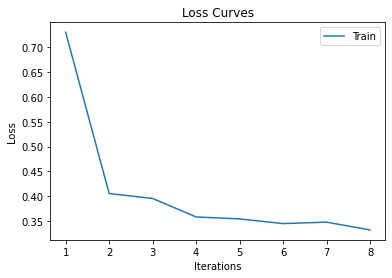

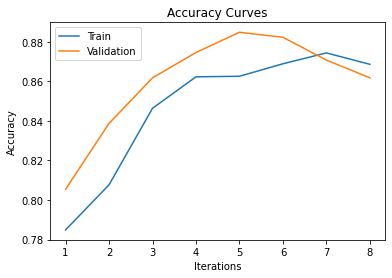

Final Training Accuracy: 0.8685510428100988
Final Validation Accuracy: 0.8617157490396927


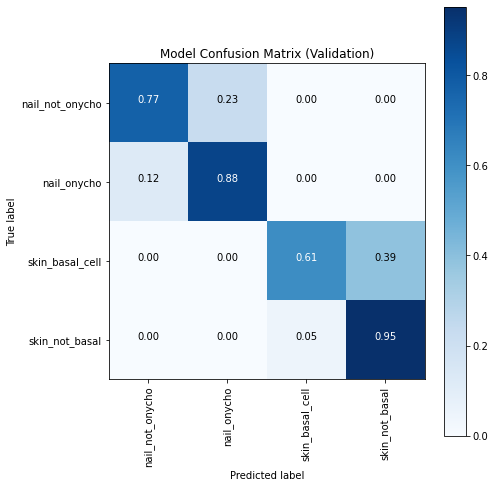

In [11]:
# Train RESNET 152 with custom FC layers
# Parameters of newly constructed modules have requires_grad=True by default
for param in resnet152.parameters():
    param.requires_grad = False

num_features = 2048
resnet152.fc = nn.Sequential(
    nn.Dropout(),
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, NUM_CLASSES) # num classes ***
)

if USE_CUDA:
  resnet152.cuda()

train(resnet152, train_data, val_data, learning_rate=0.002, batch_size=128, iterations=8, dropout=True)

## Test and Save Model

In [12]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=128,
    shuffle=False,
    num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=128,
    shuffle=False,
    num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=128,
    shuffle=False,
    num_workers=0
)
print('cell complete')

cell complete


In [14]:
# code to [load, test, save] best model checkpoint
model_final = models.resnet152(pretrained=True)
for param in model_final.parameters():
    param.requires_grad = False
num_features = 2048
# MAKE SURE MODEL IS SAME AS ONE USED FOR TRAINING
model_final.fc = nn.Sequential(
    nn.Dropout(),
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, NUM_CLASSES) # num classes ***
)
print('cell complete')

cell complete


Final Model Train Accuracy: 0.8625137211855104
Final Model Validation Accuracy: 0.8847631241997439
Final Model Test Accuracy: 0.8567774936061381


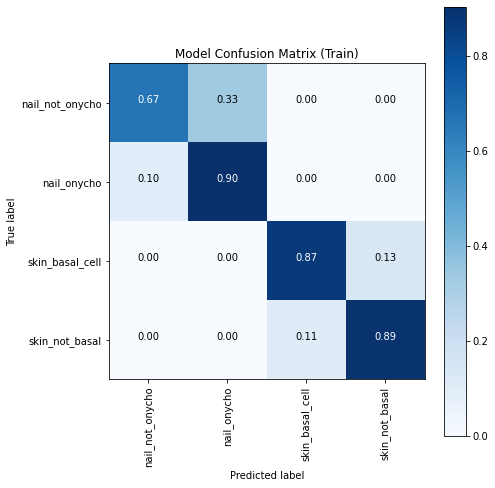

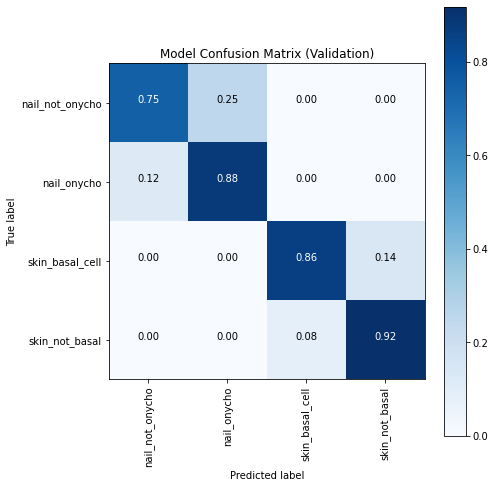

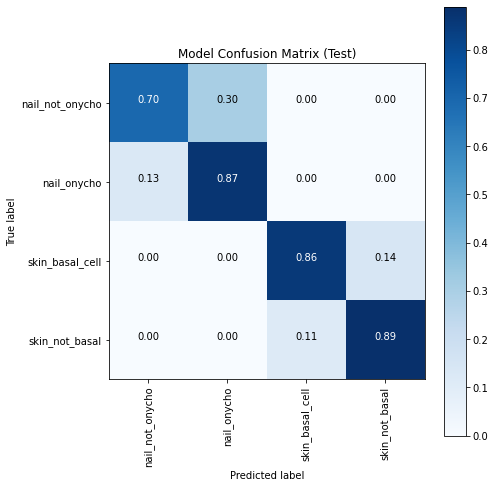

In [19]:
# INSERT FILENAME
model_final.load_state_dict(torch.load("model_ForeSight_iter5_date19_03_2021-23_12"))
if USE_CUDA:
    model_final = model_final.cuda()
model_final.eval()

print("Final Model Train Accuracy:", get_accuracy(model_final, torch.utils.data.DataLoader(train_data, batch_size=128)))
print("Final Model Validation Accuracy:", get_accuracy(model_final, torch.utils.data.DataLoader(val_data, batch_size=128)))
print("Final Model Test Accuracy:", get_accuracy(model_final, torch.utils.data.DataLoader(test_data, batch_size=128)))

# model_final.eval()
# Train confusion matrix
preds,targets=get_all_preds(model_final,train_loader,valid=True)
cm=confusion_matrix(targets.cpu(),preds.argmax(1).cpu())
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, CLASSES, title="Model Confusion Matrix (Train)", normalize=True)
# Validation confusion matrix
preds,targets=get_all_preds(model_final,val_loader,valid=True)
cm=confusion_matrix(targets.cpu(),preds.argmax(1).cpu())
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, CLASSES, title="Model Confusion Matrix (Validation)", normalize=True)
# Test confusion matrix
preds,targets=get_all_preds(model_final,test_loader,valid=True)
cm=confusion_matrix(targets.cpu(),preds.argmax(1).cpu())
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, CLASSES, title="Model Confusion Matrix (Test)", normalize=True)

In [21]:
torch.save(model_final.eval().state_dict(), "foresight_final")